# Classification

In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import matplotlib.pyplot as plt


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# this is our awesome diabetes data
diabetes = pd.read_csv('data/pima-indians-diabetes.csv')
diabetes.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,6,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,1,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,8,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,1,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


In [3]:
diabetes.columns

Index(['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree', 'Age', 'Class', 'Group'],
      dtype='object')

In [4]:
# feature engineering: normalization
# some explainer: https://developers.google.com/machine-learning/data-prep/transform/normalization
# basically we want all the numeric features scaled to the same range so the model doesnt get confused LOL
cols_to_norm = ['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps', 'Insulin', 'BMI', 'Pedigree']
diabetes[cols_to_norm] = diabetes[cols_to_norm].apply( lambda x: ( x - x.min() ) / ( x.max() - x.min() ) )

In [5]:
diabetes.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


In [6]:
# lets start by creating our features
num_preg = tf.feature_column.numeric_column('Number_pregnant')
plasma_gluc = tf.feature_column.numeric_column('Glucose_concentration')
dias_pres = tf.feature_column.numeric_column('Blood_pressure')
tricep = tf.feature_column.numeric_column('Triceps')
insulin = tf.feature_column.numeric_column('Insulin')
bmi = tf.feature_column.numeric_column('BMI')
diabetes_pedigree = tf.feature_column.numeric_column('Pedigree')
age = tf.feature_column.numeric_column('Age')

In [7]:
# special feature: categorical
assigned_group = tf.feature_column.categorical_column_with_vocabulary_list('Group',['A','B','C','D'])

# if you are using DNN, you must use embedding column, otherwise you will get an error during training
assigned_group = tf.feature_column.embedding_column(assigned_group,dimension=4)

# alternative: whenever you are too lazy to enumerate the values
# assigned_group = tf.feature_column.categorical_column_with_hash_bucket('Group',hash_bucket_size=4)

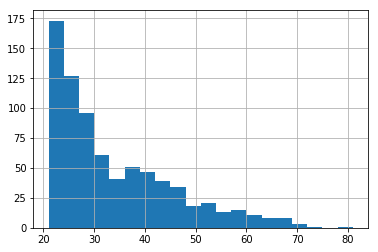

In [8]:
diabetes['Age'].hist(bins=20)

In [9]:
# sometimes we might want to convert continuos data into categorical data
# bucketing
assigned_age_bucket = tf.feature_column.bucketized_column(age,boundaries=[20,30,40,50,60,70,80])

In [10]:
# step 1: extract our features: 
feat_cols = [num_preg,plasma_gluc,dias_pres,tricep,insulin,bmi,diabetes_pedigree,assigned_age_bucket,assigned_group]

In [11]:
x_data = diabetes.drop('Class',axis=1)
x_data.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Group
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,B
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,C
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,B
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,B
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,C


In [12]:
# step 2: define our labels (the part we are trying to predict)
labels = diabetes['Class']
labels.head()

0    1
1    0
2    1
3    0
4    1
Name: Class, dtype: int64

In [13]:
# step 3: split our training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data,labels,test_size=0.3)

In [14]:
X_train.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Group
752,0.176471,0.542714,0.508197,0.242424,0.000000,0.387481,0.061913,25,C
151,0.235294,0.572864,0.532787,0.000000,0.000000,0.326379,0.151153,37,C
126,0.176471,0.603015,0.573770,0.303030,0.159574,0.639344,0.159693,30,D
330,0.470588,0.592965,0.590164,0.191919,0.000000,0.344262,0.596926,46,D
71,0.294118,0.698492,0.524590,0.353535,0.165485,0.426230,0.142186,26,B


In [15]:
# create the estimator
#model = tf.estimator.LinearClassifier(feat_cols,n_classes=2)
model = tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0ukv46pw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3aed397b00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [16]:
# train it with our training data
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)
model.train(input_fn=input_func,steps=1000)

# if you get an error during DNN training, you might want to uncomment this code from above:
# assigned_group = tf.feature_column.embedding_column(assigned_group,dimension=4)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was 

In [17]:
# evaluate the accuracy of the model
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=10,num_epochs=1,shuffle=False)
results = model.evaluate(input_fn=eval_input_func)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-04T08:38:42Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0ukv46pw/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-04-04-08:38:44
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.76623374, accuracy_baseline = 0.64069265, auc = 0.8334012, auc_precision_recall = 0.7202892, average_loss = 0.48015177, global_step = 1000, label/mean = 0.35930735, loss = 4.621461, precision = 0.6933333, prediction/mean = 0.33511257, recall = 0.62650603
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp0ukv46pw/model.ckpt-1000


In [18]:
results

{'accuracy': 0.76623374,
 'accuracy_baseline': 0.64069265,
 'auc': 0.8334012,
 'auc_precision_recall': 0.7202892,
 'average_loss': 0.48015177,
 'label/mean': 0.35930735,
 'loss': 4.621461,
 'precision': 0.6933333,
 'prediction/mean': 0.33511257,
 'recall': 0.62650603,
 'global_step': 1000}

In [21]:
# run a prediction
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=10,num_epochs=1,shuffle=False)

predictions = list(model.predict(pred_input_func))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0ukv46pw/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [20]:
# extract the predictions
#predictions = []

#for pred in list(estimator.predict(input_predict_func)):
#    predictions.append(pred['predictions'])